In [1]:
%matplotlib inline

In [2]:
from matplotlib.pylab import *

In [3]:
rc('figure', figsize=(8, 4))
rc('savefig', bbox='tight')
plt.rcParams.update({'font.size': 16})

import numpy as np
import torch
import torch.nn as nn
from models import resnet18_narrow as resnet18
from utils import get_loader
from utils.train_utils import AverageMeter, accuracy
import argparse
from sklearn.model_selection import ParameterGrid
import pickle
from tqdm import tqdm 
import copy
import glob
import numpy as np
import scipy
import copy

In [4]:
all_measures = ["eig_max", "fro_norm", "eig_trace", "d_eff", "eps_flat", "pac_bayes", "fim", "shannon_entropy", "local_entropy_grad_norm", "low_pass"]
labels = ["$\lambda_{max}(H)$", "$||H||_{F}$", "Trace(H)", "$d_{eff}$", "$\epsilon$ sharpness", "$\mu_{PAC-Bayes}$", "FRN", "Shannon","$\mu_{LE}$", "LPF"]

ln = [i/10 for i in range(10)]

gen_gap = np.zeros((10, 5))
sharpness = np.zeros((len(all_measures), 10, 5)) # measures x noise x seed 

for k in range(5):
    for j in range(10):
        fol = f"checkpoints/cifar10_ln/resnet_label_noise_{j / 10}/run_ms_{k}/measures.pkl"
        with open(fol, 'rb') as f:
            mtr = pickle.load(f)    
        gen_gap[j,k] = (-mtr["val_acc"] + mtr["train_acc"])
        for i,meas in enumerate(all_measures, 0):
            if meas == "eig_max" or meas=="d_eff":
                fol = f"checkpoints/cifar10_ln/resnet_label_noise_{j / 10}/run_ms_{k}/eig_val.npy"
                eig_val = np.load(fol)
                if meas == "eig_max": sharpness[i,j,k] = np.max(eig_val)
                if meas=="d_eff": sharpness[i,j,k] = np.sum(eig_val / (eig_val + 1))
            else:
                sharpness[i,j,k] = mtr[meas]
        
sharpness_mean = np.mean(sharpness, 2)
sharpness_std = np.std(sharpness, 2)
sharpness_mean = sharpness_mean - np.min(sharpness_mean, 1).reshape(-1,1)
sharpness_mean = sharpness_mean / np.max(sharpness_mean, 1).reshape(-1,1)
sharpness = sharpness_mean

gen_gap = np.mean(gen_gap, 1)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


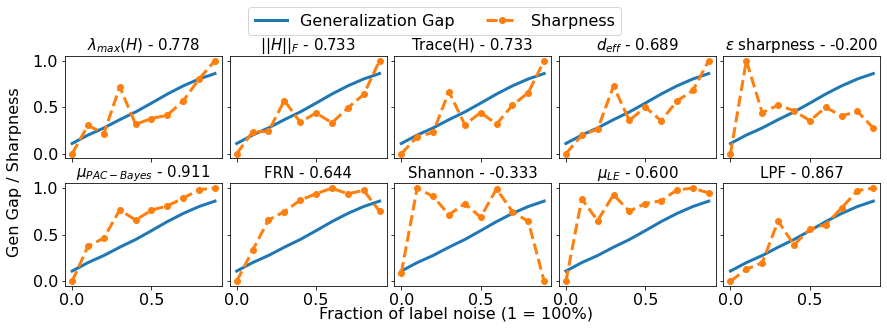

In [7]:
fig, axs = plt.subplots(2, 5, figsize=(12,4), sharex=True, sharey=True)

i=0
for meas,ax in zip(all_measures, axs.ravel()):
    ax.plot(ln, gen_gap/100, label="", linewidth=3)
    ax.plot(ln, sharpness[i,:], label="", linewidth=3, marker='o', linestyle="--")
    ax.set_title(f"{labels[i]} - {scipy.stats.kendalltau(ln, sharpness_mean[i,:])[0]:0.3f}", fontsize=15)
    i+=1

fig.legend(["Generalization Gap", "Sharpness"],ncol=2, bbox_to_anchor=(0.7, 1.1))
fig.text(0.5, -0.01, 'Fraction of label noise (1 = 100%)', ha='center')
fig.text(-0.02, 0.5, 'Gen Gap / Sharpness', va='center', rotation='vertical')
plt.tight_layout(pad=0.5, w_pad=0.0, h_pad=0.0)
fig.savefig("results/nips/ln.eps")

# for i,meas in enumerate(all_measures,0):
#     print(f"{meas} & ", end="")
# print("")
# for i,meas in enumerate(all_measures,0):
#     print(f"{scipy.stats.kendalltau(dn, sharpness_mean[i,:])[0]:0.4f} &", end=' ')
    

In [ ]:
fig, ax = plt.subplots(figsize=(12,4))
ax.plot(ln, gen_gap/100, label=f"Gen Gap",linewidth=2)

for i,meas in enumerate(all_measures,0):    
    ax.plot(ln, sharpness[i,:], label=f"{labels[i]}",linewidth=2, marker='o', linestyle="--", alpha=0.7)

ax.plot(ln, sharpness[-2,:], label="Eig-Max",linewidth=2, marker='o', linestyle="--", alpha=0.7)
ax.plot(ln, sharpness[-1,:], label="$d_{eff}$",linewidth=2, marker='o', linestyle="--", alpha=0.7)

ax.legend(fontsize=13, loc=2, bbox_to_anchor=(1, 1))
    
plt.tight_layout()
plt.xlabel('Fraction of label noise (1 = 100%)')
plt.ylabel('Generalization Gap / Sharpness')

labels.append("Eig-Max")
labels.append("d_{eff}")
for i in range(10):
    print(f"{labels[i]} & {scipy.stats.kendalltau(ln, sharpness_mean[i,:])[0]:0.3f} &")

plt.grid()
plt.savefig(f"results/nips/ln.eps", bbox_inches='tight')